### Cell 1: Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tabulate import tabulate
from sklearn.metrics import roc_auc_score, roc_curve

warnings.filterwarnings("ignore")

## Load Vectorized Matrices from Pickle Files

In [2]:
import pickle

# Load the BoW vectorized matrices
with open('X_train_bow.pkl', 'rb') as f:
    X_train_bow = pickle.load(f)
with open('X_cv_bow.pkl', 'rb') as f:
    X_cv_bow = pickle.load(f)
with open('X_test_bow.pkl', 'rb') as f:
    X_test_bow = pickle.load(f)

# Load the TF-IDF vectorized matrices
with open('X_train_tfidf.pkl', 'rb') as f:
    X_train_tfidf = pickle.load(f)
with open('X_cv_tfidf.pkl', 'rb') as f:
    X_cv_tfidf = pickle.load(f)
with open('X_test_tfidf.pkl', 'rb') as f:
    X_test_tfidf = pickle.load(f)

# Load the Word2Vec vectorized matrices
with open('X_train_w2v.pkl', 'rb') as f:
    X_train_w2v = pickle.load(f)
with open('X_cv_w2v.pkl', 'rb') as f:
    X_cv_w2v = pickle.load(f)
with open('X_test_w2v.pkl', 'rb') as f:
    X_test_w2v = pickle.load(f)
    
    
    

# Load the y datasets from local files
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('y_cv.pkl', 'rb') as f:
    y_cv = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)    
    

In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def perform_grid_search_cv_xgboost(X_cv, y_cv, n_splits=3):
    """
    Perform Grid Search Cross-Validation to find the optimal hyperparameters for XGBoost using StratifiedKFold with fewer splits.
    """
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, verbosity=0), 
                               param_grid=param_grid, 
                               cv=stratified_kfold, 
                               n_jobs=-1, 
                               verbose=3, 
                               scoring='accuracy')
    grid_search.fit(X_cv, y_cv)
    best_params = grid_search.best_params_
    cv_scores = grid_search.cv_results_['mean_test_score']
    return best_params, cv_scores

def plot_cv_error(cv_scores, params):
    """
    Plot the Cross-Validation error for different hyperparameter values.
    """
    mse = [1 - x for x in cv_scores]
    plt.figure(figsize=(8, 8))
    plt.plot(range(len(params)), mse, linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    for i, (param, score) in enumerate(zip(params, mse)):
        plt.annotate(f'({param}, {score:.3f})', (i, score), textcoords='data')
    plt.title('CV Error vs Hyperparameter Values')
    plt.xlabel('Hyperparameter Index')
    plt.ylabel('CV Error')
    plt.show()

In [9]:
def evaluate_xgboost(X_train, y_train, X_test, y_test, params, vectorizer_type):
    """
    Train and evaluate an XGBoost classifier, and plot the confusion matrix and ROC curve.
    """
    print(f"Training XGBoost model with parameters: {params}")
    xgboost = XGBClassifier(n_estimators=params['n_estimators'], 
                            max_depth=params['max_depth'], 
                            learning_rate=params['learning_rate'], 
                            use_label_encoder=False, 
                            verbosity=0)
    xgboost.fit(X_train, y_train)
    print("Training completed. Evaluating the model...")
    y_pred = xgboost.predict(X_test)
    y_pred_proba = xgboost.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Confusion Matrix
    class_labels = np.unique(y_test)
    df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    sns.heatmap(df_cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix - {vectorizer_type}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_table = tabulate(report_df, headers='keys', tablefmt='pretty')

    print("Classification Report:")
    print(report_table)

    # Print Accuracy Percentage
    accuracy_percentage = accuracy * 100
    print(f"Accuracy: {accuracy_percentage:.2f}%")
    print(f"ROC AUC Score: {roc_auc:.2f}")

    return accuracy, report, roc_auc

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Optimal Parameters for XGBoost (CV) with BoW are: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}


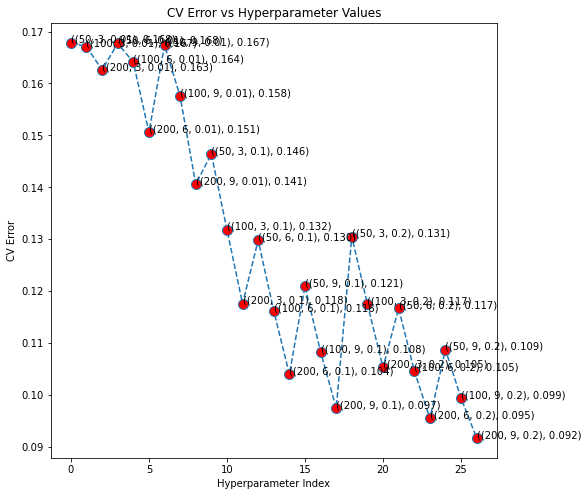

In [10]:
# Perform Grid Search CV for BoW using XGBoost on CV data with fewer splits
best_params_cv_bow, cv_scores_cv_bow = perform_grid_search_cv_xgboost(X_cv_bow, y_cv, n_splits=5)
print('Optimal Parameters for XGBoost (CV) with BoW are:', best_params_cv_bow)

# Define the hyperparameter values used in the grid search
params = [(50, 3, 0.01), (100, 3, 0.01), (200, 3, 0.01), (50, 6, 0.01), (100, 6, 0.01), (200, 6, 0.01), 
          (50, 9, 0.01), (100, 9, 0.01), (200, 9, 0.01), (50, 3, 0.1), (100, 3, 0.1), (200, 3, 0.1), 
          (50, 6, 0.1), (100, 6, 0.1), (200, 6, 0.1), (50, 9, 0.1), (100, 9, 0.1), (200, 9, 0.1), 
          (50, 3, 0.2), (100, 3, 0.2), (200, 3, 0.2), (50, 6, 0.2), (100, 6, 0.2), (200, 6, 0.2), 
          (50, 9, 0.2), (100, 9, 0.2), (200, 9, 0.2)]
plot_cv_error(cv_scores_cv_bow, params)

Training and evaluating XGBoost model for BoW on Test Data...
Training XGBoost model with parameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}
Training completed. Evaluating the model...


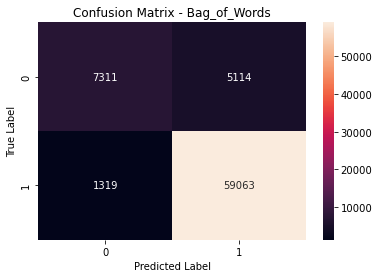

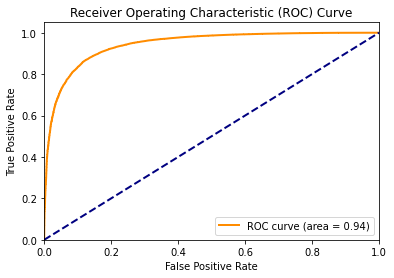

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.8471610660486675 |  0.58841046277666  | 0.6944668724768464 |      12425.0       |
|      1       | 0.9203141312308147 | 0.9781557417773509 | 0.9483537921788068 |      60382.0       |
|   accuracy   | 0.9116431112393039 | 0.9116431112393039 | 0.9116431112393039 | 0.9116431112393039 |
|  macro avg   | 0.8837375986397411 | 0.7832831022770055 | 0.8214103323278266 |      72807.0       |
| weighted avg | 0.9078300729000474 | 0.9116431112393039 | 0.905026296508104  |      72807.0       |
+--------------+--------------------+--------------------+--------------------+--------------------+
Accuracy: 91.16%
ROC AUC Score: 0.94
Accuracy (Test) with BoW: 0.911

In [13]:
# Evaluate XGBoost for BoW on Test Data
print("Training and evaluating XGBoost model for BoW on Test Data...")
accuracy_bow, report_bow, roc_auc_bow = evaluate_xgboost(X_train_bow, y_train, X_test_bow, y_test, best_params_cv_bow, 'Bag_of_Words')
print(f'Accuracy (Test) with BoW: {accuracy_bow}')
print(f'ROC AUC Score (Test) with BoW: {roc_auc_bow}')
print(f'Classification Report (Test) with BoW:\n', report_bow)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Optimal Parameters for XGBoost (CV) with TF-IDF are: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}


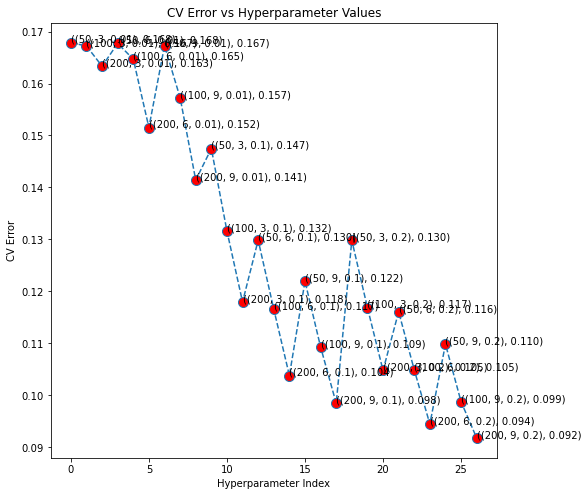

In [14]:
# Perform Grid Search CV for TF-IDF using XGBoost on CV data with fewer splits
best_params_cv_tfidf, cv_scores_cv_tfidf = perform_grid_search_cv_xgboost(X_cv_tfidf, y_cv, n_splits=5)
print('Optimal Parameters for XGBoost (CV) with TF-IDF are:', best_params_cv_tfidf)

# Define the hyperparameter values used in the grid search
params = [(50, 3, 0.01), (100, 3, 0.01), (200, 3, 0.01), (50, 6, 0.01), (100, 6, 0.01), (200, 6, 0.01), 
          (50, 9, 0.01), (100, 9, 0.01), (200, 9, 0.01), (50, 3, 0.1), (100, 3, 0.1), (200, 3, 0.1), 
          (50, 6, 0.1), (100, 6, 0.1), (200, 6, 0.1), (50, 9, 0.1), (100, 9, 0.1), (200, 9, 0.1), 
          (50, 3, 0.2), (100, 3, 0.2), (200, 3, 0.2), (50, 6, 0.2), (100, 6, 0.2), (200, 6, 0.2), 
          (50, 9, 0.2), (100, 9, 0.2), (200, 9, 0.2)]
plot_cv_error(cv_scores_cv_tfidf, params)

Training and evaluating XGBoost model for TF-IDF on Test Data...
Training XGBoost model with parameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}
Training completed. Evaluating the model...


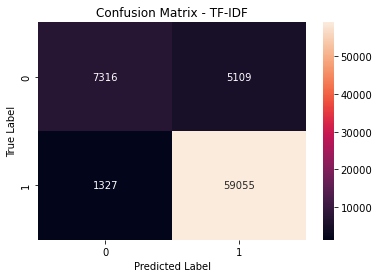

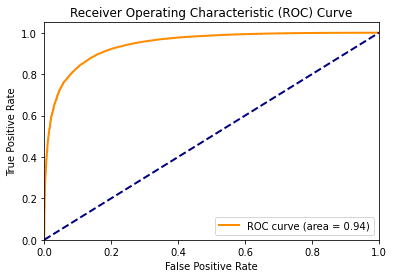

Classification Report:
+--------------+--------------------+--------------------+--------------------+-------------------+
|              |     precision      |       recall       |      f1-score      |      support      |
+--------------+--------------------+--------------------+--------------------+-------------------+
|      0       | 0.8464653476802037 | 0.5888128772635814 | 0.6945130055059806 |      12425.0      |
|      1       | 0.9203759117262016 | 0.9780232519625054 | 0.9483243139081142 |      60382.0      |
|   accuracy   | 0.911601906410098  | 0.911601906410098  | 0.911601906410098  | 0.911601906410098 |
|  macro avg   | 0.8834206297032026 | 0.7834180646130434 | 0.8214186597070474 |      72807.0      |
| weighted avg | 0.9077625811635973 | 0.911601906410098  | 0.9050097218098749 |      72807.0      |
+--------------+--------------------+--------------------+--------------------+-------------------+
Accuracy: 91.16%
ROC AUC Score: 0.94
Accuracy (Test) with TF-IDF: 0.911601906

In [15]:
# Evaluate XGBoost for TF-IDF on Test Data
print("Training and evaluating XGBoost model for TF-IDF on Test Data...")
accuracy_tfidf, report_tfidf, roc_auc_tfidf = evaluate_xgboost(X_train_tfidf, y_train, X_test_tfidf, y_test, best_params_cv_tfidf, 'TF-IDF')
print(f'Accuracy (Test) with TF-IDF: {accuracy_tfidf}')
print(f'ROC AUC Score (Test) with TF-IDF: {roc_auc_tfidf}')
print(f'Classification Report (Test) with TF-IDF:\n', report_tfidf)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Optimal Parameters for XGBoost (CV) with Word2Vec are: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}


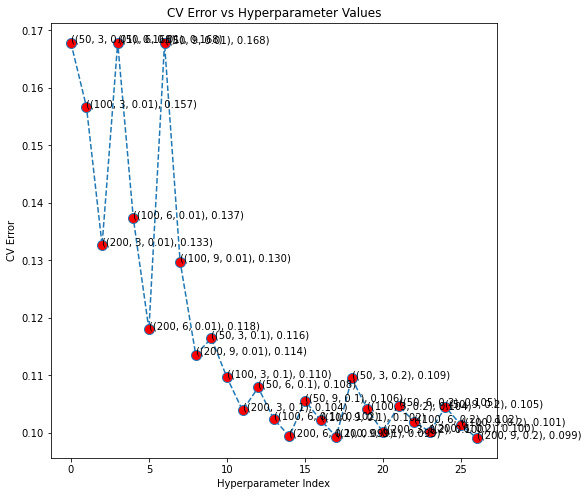

In [16]:
# Perform Grid Search CV for Word2Vec using XGBoost on CV data with fewer splits
best_params_cv_w2v, cv_scores_cv_w2v = perform_grid_search_cv_xgboost(X_cv_w2v, y_cv, n_splits=5)
print('Optimal Parameters for XGBoost (CV) with Word2Vec are:', best_params_cv_w2v)

# Define the hyperparameter values used in the grid search
params = [(50, 3, 0.01), (100, 3, 0.01), (200, 3, 0.01), (50, 6, 0.01), (100, 6, 0.01), (200, 6, 0.01), 
          (50, 9, 0.01), (100, 9, 0.01), (200, 9, 0.01), (50, 3, 0.1), (100, 3, 0.1), (200, 3, 0.1), 
          (50, 6, 0.1), (100, 6, 0.1), (200, 6, 0.1), (50, 9, 0.1), (100, 9, 0.1), (200, 9, 0.1), 
          (50, 3, 0.2), (100, 3, 0.2), (200, 3, 0.2), (50, 6, 0.2), (100, 6, 0.2), (200, 6, 0.2), 
          (50, 9, 0.2), (100, 9, 0.2), (200, 9, 0.2)]
plot_cv_error(cv_scores_cv_w2v, params)

Training and evaluating XGBoost model for W2V on Test Data...
Training XGBoost model with parameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}
Training completed. Evaluating the model...


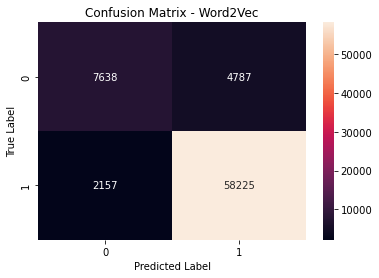

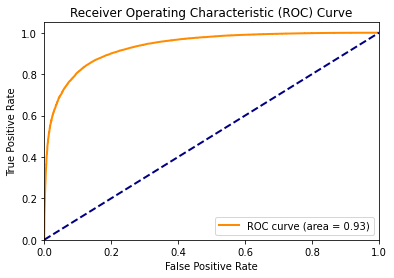

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.7797856049004595 | 0.614728370221328  | 0.6874887488748875 |      12425.0       |
|      1       | 0.9240303434266489 | 0.9642774336722865 | 0.9437249785240773 |      60382.0       |
|   accuracy   | 0.9046245553312181 | 0.9046245553312181 | 0.9046245553312181 | 0.9046245553312181 |
|  macro avg   | 0.8519079741635542 | 0.7895029019468072 | 0.8156068636994824 |      72807.0       |
| weighted avg | 0.8994140170268811 | 0.9046245553312181 | 0.8999965574465548 |      72807.0       |
+--------------+--------------------+--------------------+--------------------+--------------------+
Accuracy: 90.46%
ROC AUC Score: 0.93
Accuracy (Test) with W2V: 0.904

In [17]:
# Evaluate XGBoost for W2V on Test Data
print("Training and evaluating XGBoost model for W2V on Test Data...")
accuracy_w2v, report_w2v, roc_auc_w2v = evaluate_xgboost(X_train_w2v, y_train, X_test_w2v, y_test, best_params_cv_w2v, 'Word2Vec')
print(f'Accuracy (Test) with W2V: {accuracy_w2v}')
print(f'ROC AUC Score (Test) with W2V: {roc_auc_w2v}')
print(f'Classification Report (Test) with W2V:\n', report_w2v)

In [18]:
import pandas as pd
from tabulate import tabulate

# Assuming you have the following variables already defined:
# accuracy_bow, report_bow, roc_auc_bow
# accuracy_tfidf, report_tfidf, roc_auc_tfidf
# accuracy_w2v, report_w2v, roc_auc_w2v

# Function to extract relevant metrics from the classification reports
def extract_overall_metrics(report):
    return {
        'Precision': report['macro avg']['precision'],
        'Recall': report['macro avg']['recall'],
        'F1-Score': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }

# Extract overall metrics for each vectorization method
metrics_bow = extract_overall_metrics(report_bow)
metrics_tfidf = extract_overall_metrics(report_tfidf)
metrics_w2v = extract_overall_metrics(report_w2v)

# Create a DataFrame to hold the data
data = {
    'Vectorization': ['BoW', 'TF-IDF', 'Word2Vec'],
    'Accuracy': [f"{metrics_bow['Accuracy'] * 100:.2f}%", f"{metrics_tfidf['Accuracy'] * 100:.2f}%", f"{metrics_w2v['Accuracy'] * 100:.2f}%"],
    'Precision': [f"{metrics_bow['Precision']:.2f}", f"{metrics_tfidf['Precision']:.2f}", f"{metrics_w2v['Precision']:.2f}"],
    'Recall': [f"{metrics_bow['Recall']:.2f}", f"{metrics_tfidf['Recall']:.2f}", f"{metrics_w2v['Recall']:.2f}"],
    'F1-Score': [f"{metrics_bow['F1-Score']:.2f}", f"{metrics_tfidf['F1-Score']:.2f}", f"{metrics_w2v['F1-Score']:.2f}"],
    'AUC': [f"{roc_auc_bow:.2f}", f"{roc_auc_tfidf:.2f}", f"{roc_auc_w2v:.2f}"]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Print the DataFrame as a pretty table without the index column
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))

+---------------+----------+-----------+--------+----------+------+
| Vectorization | Accuracy | Precision | Recall | F1-Score | AUC  |
+---------------+----------+-----------+--------+----------+------+
|      BoW      |  91.16%  |   0.88    |  0.78  |   0.82   | 0.94 |
|    TF-IDF     |  91.16%  |   0.88    |  0.78  |   0.82   | 0.94 |
|   Word2Vec    |  90.46%  |   0.85    |  0.79  |   0.82   | 0.93 |
+---------------+----------+-----------+--------+----------+------+
